In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
from snkrfinder.imports import *
from snkrfinder.core import *
from snkrfinder.data.munge import *
from snkrfinder.model.core import *
from snkrfinder.model.cvae import *

from fastai.test_utils import show_install, synth_learner, nvidia_smi, nvidia_mem

# train some architectures and save for testing inference.



## OVERVIEW: cvae module - convolutional variational auto encoder

preamble: This is a project initiated while an Insight Data Science fellow.  It grew out of my interest in making data driven tools in the fashion/retail space I had most recently been working.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some initial sneakers based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.

> NOTE: removing the nbdev tags ? actually pause for now...maybe a tutorial entry will be nice.


In [ ]:
#hide
show_install()



```text
=== Software === 
python        : 3.8.2
fastai        : 2.2.7
fastcore      : 1.3.19
fastprogress  : 0.2.7
torch         : 1.7.1
nvidia driver : 460.56
torch cuda    : 11.0 / is available
torch cudnn   : 8005 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : GeForce RTX 2070 SUPER

=== Environment === 
platform      : Linux-5.8.0-7642-generic-x86_64-with-glibc2.10
distro        : #47~1614007149~20.10~82fb226-Ubuntu SMP Tue Feb 23 02:59:01 UTC 
conda env     : fastai
python        : /home/ergonyc/anaconda3/envs/fastai/bin/python
sys.path      : /home/ergonyc/Projects/Project2.0/snkrfinder/nbs
/home/ergonyc/anaconda3/envs/fastai/lib/python38.zip
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/lib-dynload

/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg
/home/ergonyc/anaconda3/envs/fastai/lib/

In [ ]:
#hide
#nvidia_smi()


In [ ]:
#hide 
# fix our base directory
print(Path().cwd())
os.chdir(L_ROOT)
print(Path().cwd())

/home/ergonyc/Projects/Project2.0/snkrfinder/nbs
/home/ergonyc/Projects/Project2.0/snkrfinder


## PREP DATA Using  fastai V2: data pipelining
- Datablock API

Load the saved merged database, and set the seeds.  And doublecheck our data is where we expect.

In [ ]:

df = pd.read_pickle(f"data/{COMBINED_DF}.pkl")
np.random.seed(3333)
torch.manual_seed(3333)


In [ ]:
#TODO:  fix the data layout... the links and paths are screwy
image_path = L_ROOT/"data"
#image_path = D_ROOT/DBS['zappos']
batch_size = 64

L([image_path/d for d in df.path])

(#11771) [Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045616.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045632.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045650.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045650.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.396.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.4854.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/80

In [ ]:
df = prep_df_for_datablocks(df)

## MMD-VAE  
> replace latent regularization term in loss_fn (KLD) with MMD

We'll make an `MMDVAE` class to keep things declarative, but its really just an `AE`.  i.e. a linear latent layer.

Additional background on MME from [https://github.com/Saswatm123/MMD-VAE]:

> Maximum Mean Discrepancy Variational Autoencoder, a member of the InfoVAE family that maximizes Mutual Information between the Isotropic Gaussian Prior (as the latent space) and the Data Distribution.\
Short explanation: The traditional VAE is known as the ELBO-VAE, named after the Evidence Lower Bound used in its objective. The ELBO suffers from two problems: overestimation of latent variance, and uninformative latent information.\
The latter is because one of the objective's terms is the KL-Divergence between the Gaussian parameterized by the encoder and the Standard Isotropic Gaussian. This dissuades usage of the latent code, so that the KL-Divergence term is allowed to fall even further. It is important to note that the KL-Divergence should never truly reach zero, as that means the encoder is not learning useful features and cannot find feature locality, and the decoder is just randomly sampling from Standard Gaussian noise.\
The overestimation of variance results from the KL-Divergence term not being strong enough to balance against the Reconstruction Error, and thus the Encoder prefers to learn a multimodal latent distribution with spread apart means, leading to low training error as it overfits, but low quality samples as well, as the sampling distribution is assumed to be a Standard Isotropic Gaussian. One effort to mitigate this effect is the Disentangled Variational Autoencoder, which simply raises the weight on the KL-Divergence term. However, this increases the problem stated in the paragraph above since it further penalizes using the latent code.\
For more detailed explanations, I used these resources to learn, in order of usefulness to me:\
    - https://arxiv.org/pdf/1706.02262.pdf \
    - http://ruishu.io/2018/03/14/vae/ \
    - http://approximateinference.org/accepted/HoffmanJohnson2016.pdf \
    - https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/ \
    - http://bjlkeng.github.io/posts/variational-bayes-and-the-mean-field-approximation/ \
    - https://ermongroup.github.io/cs228-notes/inference/variational/ \

#### Vanilla MMD VAE


In [ ]:
latent_dim = 128

block = get_ae_DataBlock(aug=True)

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]


alpha = 20

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch='vanilla'
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    

In [ ]:
learn.name

'vanilla'

(0.33113112449646,
 0.12022644281387329,
 0.22567878365516664,
 0.19952622056007385)

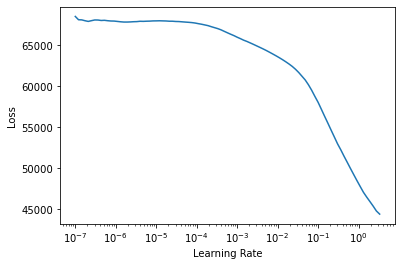

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr

# WARNING... the loss is way way way too high. to start with... so the numbers a bogus... 
# 10-3 is a good place to start

epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time
0,63537.976562,61971.996094,61952.085938,14.658663,0.122171,0.454403,65298.691406,0.757889,-1.693446,1432.249268,1945.973633,0.652042,00:18
1,61262.660156,59384.238281,59371.746094,7.246908,0.072884,0.444950,64513.214844,0.621752,-1.750224,1193.765747,1757.061035,0.673011,00:17
2,60153.023438,58910.832031,58900.425781,4.884755,0.033997,0.438681,64334.531250,0.572339,-1.776659,1132.446533,1700.333130,0.657225,00:17
3,59496.519531,58555.789062,58544.917969,5.320944,0.030812,0.469082,64135.097656,0.608627,-1.658157,1175.006592,1647.105835,0.721956,00:17
4,58934.613281,57976.746094,57957.898438,13.267242,0.042864,0.577800,63629.398438,0.843570,-1.309009,1508.523193,1853.448608,0.905926,00:17
5,58189.277344,56955.882812,56931.085938,19.661865,0.050523,0.589403,62852.367188,0.935740,-1.270907,1642.946167,2051.485352,0.915524,00:17
6,57113.363281,55664.980469,55645.097656,14.787601,0.041574,0.491804,61790.546875,0.793442,-1.581855,1421.808472,1934.405273,0.796465,00:17
7,55830.347656,54265.804688,54249.226562,11.764241,0.041968,0.433818,60630.390625,0.698280,-1.817262,1268.404419,1964.367554,0.754022,00:17
8,54428.289062,52803.000000,52788.316406,10.259772,0.044155,0.387246,59450.015625,0.637815,-2.022072,1186.320312,2058.029297,0.691211,00:17
9,52978.007812,51274.093750,51259.429688,10.423711,0.050323,0.362169,58244.738281,0.622037,-2.133025,1193.265869,2142.626953,0.621162,00:17


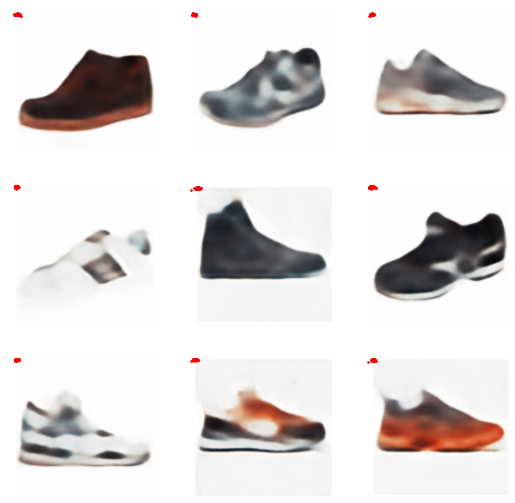

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 200
# learn.fit_flat_cos(n_epoch, lr=1e-2)
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.1)
# n_epoch = 10
learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

#### Higher alpha = 20

In [ ]:
latent_dim = 128

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 20

batchmean = True
useL1 = False

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


In [ ]:
arch='vanilla'
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    

(0.33113112449646,
 0.0691830962896347,
 0.20015711039304734,
 0.15135611593723297)

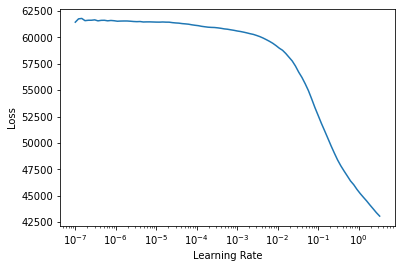

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr

# WARNING... the loss is way way way too high. to start with... so the numbers a bogus... 
# 10-3 is a good place to start

epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time
0,51835.109375,48239.332031,48200.558594,31.128502,-0.024991,2.253334,58136.320312,2.903346,1.015503,2974.831787,20103.091797,1.392713,00:18
1,41959.472656,33240.875000,33170.175781,64.681511,-0.017793,1.730978,48334.824219,2.329598,0.816916,3746.965332,10107.454102,0.869169,00:17
2,33047.246094,25083.667969,24943.236328,134.215256,-0.032771,2.465609,41080.449219,3.276918,1.598844,5671.732910,20556.599609,0.765673,00:17
3,24870.820312,18667.085938,18566.369141,96.194756,-0.082224,2.032734,34693.457031,2.652338,1.292141,5131.601074,12103.342773,0.674018,00:17
4,18305.291016,13598.246094,13485.920898,109.052002,-0.086591,2.157692,28898.296875,2.808273,1.428876,5538.612793,13651.482422,0.634565,00:18
5,13486.014648,10443.436523,10338.751953,101.413612,-0.056157,2.341367,24520.273438,2.918143,1.609080,5724.416016,15276.041992,0.578494,00:17
6,10108.318359,8028.006348,7908.431152,117.607170,-0.098993,2.420249,20507.751953,3.051109,1.683126,5986.417480,16677.408203,0.558408,00:17
7,7806.714355,6530.937988,6419.393555,109.960320,-0.087472,2.493459,17554.998047,3.083296,1.741315,5974.233887,17375.923828,0.562799,00:17
8,6302.827637,5654.237793,5537.212402,115.250298,-0.073476,2.586817,15404.299805,3.187805,1.814324,6142.896484,18784.451172,0.568338,00:17
9,5310.229492,5024.891602,4926.652832,97.256935,-0.089881,2.480210,13768.073242,3.011726,1.733256,5811.323730,16703.335938,0.561846,00:17


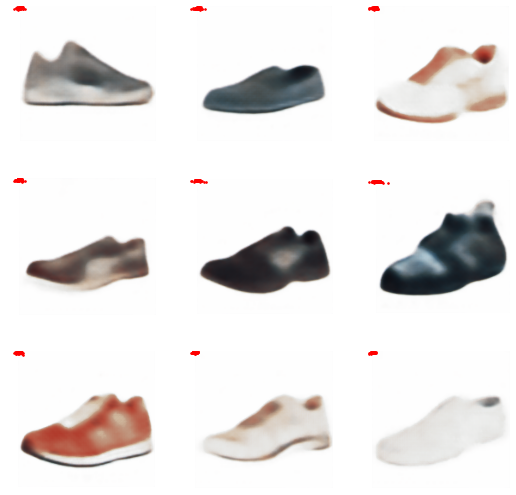

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 100
learn.fit_flat_cos(n_epoch)#, lr=lr1)
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.1)
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### ResNet Encoder MMDVAE

In [ ]:
# # arch = resnet50(pretrained=True)
# # cut = model_meta[resnet50]['cut']
# # enc_arch = list(arch.children())[:cut]
# # nn.Sequential(*enc_arch).cuda()(x).shape
# arch=resnet18
# cut = model_meta[arch]['cut']
# arch = arch(pretrained=True)
# enc_arch = list(arch.children())[:cut]
# enc_dim = 512
# vae = MMDVAE(enc_arch,enc_dim=enc_dim, hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)


####  L2 error func

In [ ]:
block = get_ae_DataBlock(aug=True)

    
    
latent_dim = 128


cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch=resnet18
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    
learn.freeze()


(0.33113112449646,
 0.14454397559165955,
 0.23783755004405976,
 0.2187761664390564)

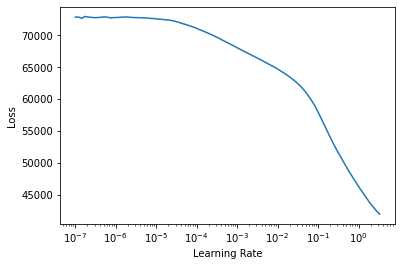

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


(0.33113112449646,
 0.14454397559165955,
 0.23783755004405976,
 0.2187761664390564)

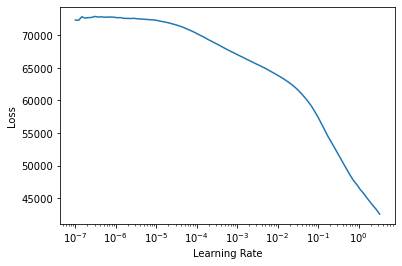

In [ ]:
learn.unfreeze()
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time
0,53410.070312,49564.449219,49062.925781,494.913483,0.311348,9.678559,58805.402344,13.692267,4.375152,12196.145508,193040.578125,0.728074,00:23
1,45035.433594,39024.082031,38735.292969,284.432800,0.080134,6.177262,50620.878906,7.875557,3.533332,7048.506836,64860.539062,0.539619,00:22
2,38238.722656,33097.093750,32839.992188,253.194229,0.097068,5.093225,46265.410156,6.626133,3.148566,6112.339844,44436.640625,0.556658,00:22
3,31201.761719,26546.714844,26296.265625,247.659821,-0.038055,4.859870,41624.378906,6.402651,3.056515,5986.105469,40919.699219,0.554190,00:22
4,25320.453125,22162.753906,21939.630859,219.735977,0.014738,4.702053,37895.242188,6.066270,3.000347,5716.769531,36843.796875,0.541559,00:22
5,20694.007812,17967.917969,17704.228516,260.627563,0.205243,4.810926,33691.316406,6.396630,3.041988,6012.168457,40379.429688,0.561934,00:22
6,17023.751953,14682.936523,14449.906250,230.101593,0.225100,4.819304,30161.648438,6.186117,3.050176,5894.942383,38549.335938,0.548785,00:22
7,14081.570312,12118.333008,11899.054688,216.494736,0.120125,4.831882,26968.980469,6.109776,3.055156,5819.543457,38016.601562,0.549044,00:22
8,11779.856445,10274.928711,10032.401367,240.649582,0.558387,4.997557,24309.953125,6.348104,3.126587,6127.143555,41119.300781,0.540480,00:22
9,9900.954102,8646.427734,8444.707031,199.850204,0.364717,4.849984,21675.589844,6.003124,3.066138,5777.208984,37308.007812,0.537948,00:22


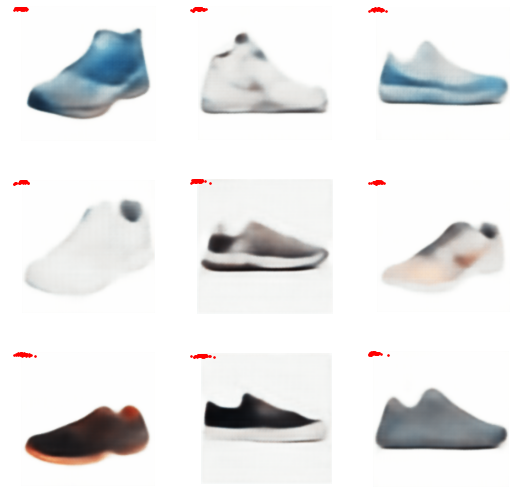

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time
0,17869.873047,15087.429688,13820.215820,1268.400269,-463.104858,7234.524414,18534.427734,18142.546875,17.365637,17387136.000000,259843604480.000000,1.374451,00:24
1,11781.827148,17495.623047,16225.350586,1268.401245,-234.925415,7824.626953,17894.464844,16394.648438,17.733858,15989523.000000,223900319744.000000,0.869804,00:24
2,9414.176758,12256.887695,10986.339844,1268.486450,-300.508759,5764.315430,15201.961914,11771.402344,17.178148,11900341.000000,113995358208.000000,0.731825,00:24
3,8076.187012,20182.261719,18907.582031,1268.350708,-231.606842,4333.430176,20002.990234,8351.229492,16.600641,8407190.000000,59088482304.000000,0.730133,00:24
4,7090.195312,7009.728027,5741.021973,1268.420532,-257.959503,4379.657227,10760.045898,8124.453613,16.619253,8101139.000000,56995844096.000000,0.733915,00:24


epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time
0,6497.443848,6859.545410,5590.933105,1268.411987,-257.617981,4407.676270,10643.764648,8168.413574,16.630856,8145062.500000,57658179584.000000,0.736908,00:24
1,6507.251465,6858.421387,5589.745605,1268.400879,-256.013641,4324.433105,10675.621094,8053.704102,16.592024,8043165.500000,55914934272.000000,0.738865,00:24
2,6490.448730,6843.237793,5574.656250,1268.373291,-260.648926,4347.500977,10639.070312,8120.376465,16.601759,8115277.000000,56778514432.000000,0.740691,00:24
3,6465.696777,6840.447754,5571.917480,1268.441040,-263.899658,4373.332031,10591.646484,8161.526855,16.613108,8152953.500000,57390190592.000000,0.741809,00:24
4,6472.214844,6836.954102,5568.391113,1268.429565,-261.817322,4342.104004,10610.264648,8099.727539,16.598921,8092180.000000,56531013632.000000,0.741640,00:24


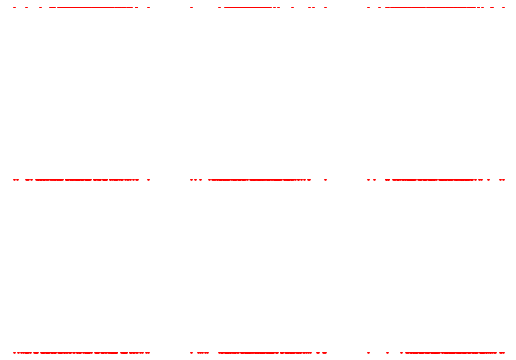

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 5
learn.unfreeze()
learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e6, pct_start=0.7)
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e5, pct_start=0.5)
learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"unfrozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

In [ ]:

    
    
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
alpha = 20

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch=resnet18
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    
learn.freeze()


(0.33113112449646,
 0.05754399299621582,
 0.1943375587463379,
 0.13803842663764954)

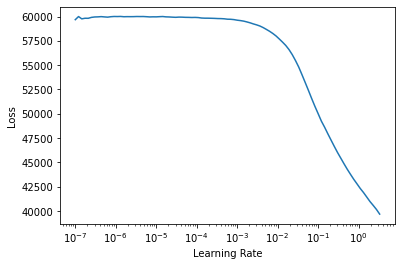

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time
0,59104.167969,58415.285156,58312.128906,97.462120,-0.029942,0.826258,62850.628906,1.781503,-0.403027,3638.153076,4198.208984,0.279273,00:22
1,58234.773438,57190.253906,57088.488281,95.621223,-0.021026,0.750047,62474.503906,1.735035,-0.599882,3582.889648,4092.819336,0.291242,00:23
2,57347.917969,56264.195312,56163.953125,94.805458,-0.034240,0.668814,62067.632812,1.687563,-0.829013,3518.443359,4039.889893,0.287013,00:22
3,56444.902344,55248.542969,55150.453125,92.630859,-0.011105,0.587697,61600.320312,1.641513,-1.089499,3462.562012,4038.033203,0.293751,00:22
4,55513.417969,54247.972656,54157.210938,85.779610,-0.013726,0.533696,61154.789062,1.564546,-1.286366,3315.570557,3898.855225,0.313445,00:22
5,54484.437500,53111.578125,53030.304688,76.029076,-0.004798,0.499689,60621.339844,1.476374,-1.425745,3147.939697,3682.844971,0.355148,00:22
6,53310.652344,51829.902344,51755.703125,69.293427,-0.049855,0.490012,60004.070312,1.409631,-1.470498,3004.205566,3487.581543,0.385412,00:22
7,51968.015625,50195.183594,50122.886719,67.552795,-0.026889,0.502816,59083.117188,1.401619,-1.428049,2979.964355,3416.008789,0.429865,00:22
8,50439.500000,48567.132812,48496.089844,66.214638,-0.027156,0.522103,58192.417969,1.398692,-1.357400,2976.043213,3340.585938,0.449237,00:22
9,48734.476562,46811.617188,46740.335938,66.979988,-0.027438,0.556406,57228.265625,1.418697,-1.233146,3001.260742,3308.828125,0.464651,00:22


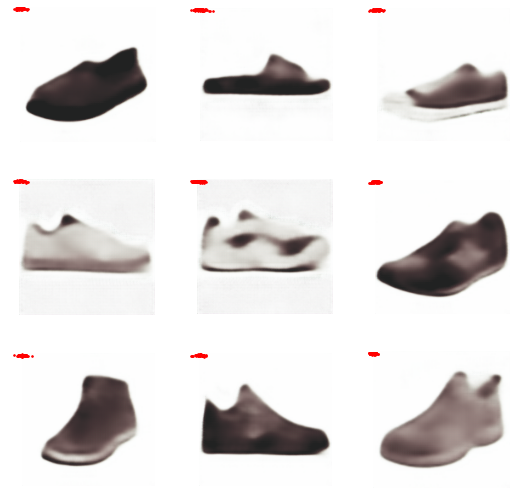

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
#learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e5, pct_start=0.5)
learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
#learn.export(f'{filename}.pkl')

Path('models/frozen-MMDVae-bmeanl2-resnet18-alpha20_2021-03-26_04.27.48.pth')

(6.309573450380412e-08,
 5.754399353463668e-06,
 2.9087475439837364e-06,
 6.025593393133022e-07)

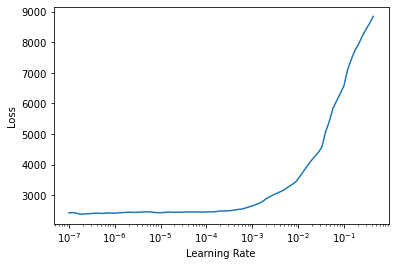

In [ ]:
learn.unfreeze()
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time
0,3100.344238,4179.433594,4024.575439,154.462570,-0.072047,3.395153,7618.819336,4.088473,2.335460,7552.745605,34512.371094,0.582519,00:24
1,3180.563477,3424.692383,3332.841064,91.165398,-0.070306,6.268805,7169.987305,7.354315,3.178729,8061.212891,158430.062500,1.015911,00:24
2,2898.826172,3021.593750,2959.646240,61.845802,-0.007719,2.535290,6658.448730,2.972969,1.668906,5105.498535,20019.708984,0.621483,00:24
3,2693.083496,2904.396240,2845.760986,58.520393,-0.031662,2.218848,6483.513184,2.605445,1.501426,4877.166504,12742.784180,0.540390,00:24
4,2557.139404,2824.285156,2767.279541,56.909004,-0.023896,2.168499,6427.261719,2.549142,1.459883,4807.514160,12023.588867,0.534968,00:24


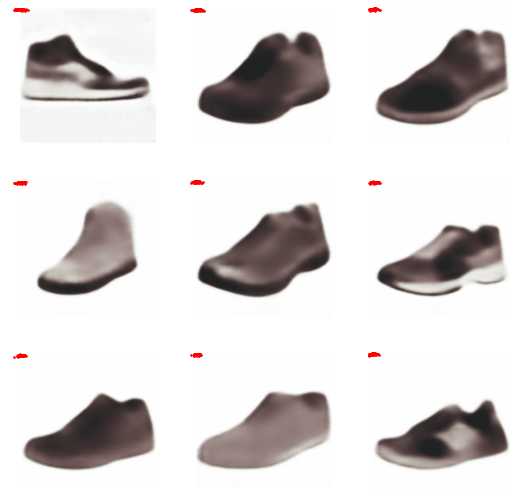

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#n_epoch = 100
#learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e6, pct_start=0.05)
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e5, pct_start=0.5)
learn.fit_one_cycle(5) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"unfrozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

### resnet arch no freeze

#### vanilla MMD VAE

In [ ]:
block = get_ae_DataBlock(aug=True)

    
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
alpha = 10

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch=resnet18
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    
learn.unfreeze()


epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time
0,50715.343750,44758.390625,44716.421875,36.775692,-0.043984,4.192410,54889.207031,5.621706,1.482148,2260.589355,107698.617188,1.173686,00:24
1,41519.453125,33293.105469,33251.433594,36.706398,-0.004156,7.094647,46232.507812,8.864800,2.380752,2789.366943,243972.781250,1.137781,00:24
2,31646.783203,23393.748047,23355.484375,33.769981,0.031931,1.766128,38381.679688,2.432050,0.628461,2006.024780,14759.514648,0.713912,00:24
3,22815.859375,16509.093750,16472.453125,33.341564,0.001989,2.697350,31410.257812,3.440934,1.113203,2266.942627,59377.914062,0.697112,00:24
4,16726.236328,12992.053711,12952.248047,37.159084,-0.801395,31.299204,26948.328125,37.790333,5.986716,9859.958984,2185096.250000,1.484773,00:24
5,12445.930664,9929.566406,9899.937500,27.469019,-0.001621,1.413758,22830.751953,1.877639,0.613524,1895.385010,2620.264648,0.552156,00:24
6,9638.571289,7955.483398,7916.150879,37.466084,-1.116697,50.567257,19324.453125,62.262054,6.593984,14262.222656,6659660.500000,1.484726,00:24
7,7631.167969,6421.007812,6388.915039,30.633488,-0.089602,11.759193,16636.007812,14.887485,3.541488,4129.154297,488954.437500,1.258746,00:23
8,6184.282227,5096.305176,5060.088867,35.141975,-0.831423,55.542549,14047.465820,68.871109,6.764207,15872.431641,7942867.000000,1.725477,00:24
9,5016.078125,4568.997559,4534.297363,33.791527,-0.162525,33.102032,12457.958008,40.790688,5.699639,9335.843750,3024754.250000,1.452757,00:24


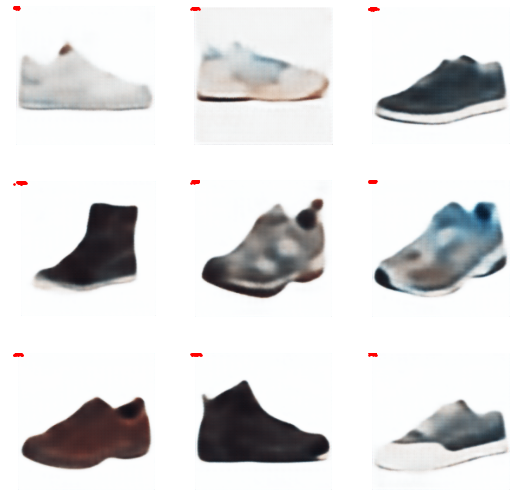

In [ ]:
n_epoch = 200
learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.1)

learn.show_results()

In [ ]:
prefix = f"MMDVae-nofreeze{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

In [ ]:
    
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
alpha = 20

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch=resnet18
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    
learn.unfreeze()


epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time
0,50369.613281,44362.250000,44317.750000,37.647671,-0.047648,22.808153,55805.621094,27.800411,4.494698,10455.324219,3148467.500000,1.754232,00:24
1,41101.511719,32957.730469,32911.523438,40.359158,0.004768,17.435198,48048.910156,21.008705,2.755113,7150.453125,3949397.750000,1.266603,00:24
2,32941.089844,27236.886719,27190.363281,39.419823,4.461135,206.219528,42611.191406,253.296814,9.551940,94969.109375,224376720.000000,1.669058,00:24
3,25506.847656,20481.689453,20402.312500,73.535919,-0.176295,13.635516,36468.785156,16.943998,3.971540,9185.491211,1374247.875000,1.480010,00:24
4,19614.015625,16146.945312,16057.434570,84.318863,0.093648,33.350922,31224.578125,41.030052,5.141617,16293.255859,8527399.000000,1.457319,00:24
5,15394.131836,12921.554688,12828.440430,88.192207,0.554965,36.813313,26579.181641,46.447880,4.374439,15220.807617,22490648.000000,1.339225,00:24
6,12087.218750,10289.758789,10207.497070,77.916306,1.450489,66.363014,22300.931641,82.175644,5.346974,25154.777344,54767584.000000,1.267864,00:24
7,9941.503906,10391.336914,10219.372070,169.805756,2.096666,117.964828,21500.689453,148.434891,8.604594,76736.148438,64927396.000000,1.874764,00:24
8,8097.748047,6941.060059,6890.188477,48.434208,-0.108777,2.014703,16259.326172,2.461123,1.032185,4053.184570,30222.380859,0.456062,00:24
9,6660.498047,5877.562988,5806.392578,69.717430,0.156558,8.243809,14654.710938,10.470905,2.096687,8833.629883,1200058.625000,0.637067,00:24


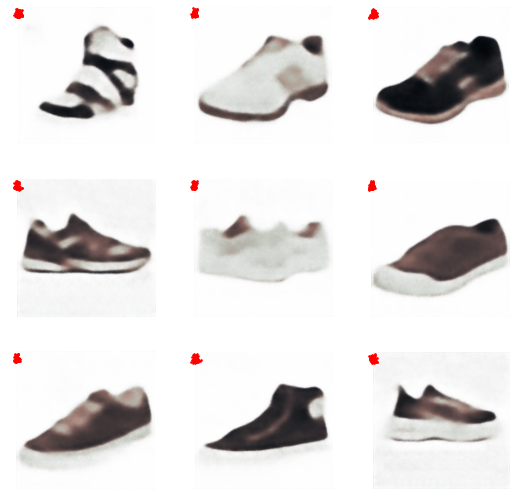

In [ ]:
n_epoch = 200
learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.1)

learn.show_results()

In [ ]:
prefix = f"MMDVae-nofreeze{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

## vanilla-resnet MMD-VAE
##### ResBlocks replacing Conv2d in encoder AND decoder.
'Vanilla' encoder made with resnet blocks instead of conv blocks and `Mish` activation

### 128 latents, alpha=10

In [ ]:
block = get_ae_DataBlock(aug=True)

latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE,isVAE=False)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    
    

    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'A'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### 128 latents, alpha=20

In [ ]:
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ShowGraphCallback(),        
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 20
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'A'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"


learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### 64 latents, alpha=10

In [ ]:
latent_dim = 64

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ShowGraphCallback(),                
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'A'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"


learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### 64 latents, alpha = 20

In [ ]:
latent_dim = 64

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ShowGraphCallback(),        
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10

batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'A'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')


### 32 latents, alpha = 20

In [ ]:
block = get_ae_DataBlock(aug=True)
latent_dim = 32

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ShowGraphCallback(),        
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10

batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'A'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### 32 latents, alpha =10, im_size = 128




In [ ]:
im_size = 128

In [ ]:
block = get_ae_DataBlock(aug=True,im_size = im_size)
latent_dim = 32

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ShowGraphCallback(),        
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10

batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch,im_size=im_size), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=im_size,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'im_size128'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

In [ ]:

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### 32 latents, alpha = 20, im_size = 128


We can't actually resize easily.  We have some bugs where the DEFAULTS are hard-coded to be IM_SIZE which defaults to 160.

In [ ]:
im_size = 128

In [ ]:
block = get_ae_DataBlock(aug=True,im_size = im_size)
latent_dim = 32

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ShowGraphCallback(),        
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10

batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch,im_size=im_size), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=im_size,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'im_size128'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### 32 latents, alpha =10, im_size = 128, batch=256


We can't actually resize easily.  We have some bugs where the DEFAULTS are hard-coded to be IM_SIZE which defaults to 160.

In [ ]:
im_size = 128

In [ ]:
block = get_ae_DataBlock(aug=True,im_size = im_size)
latent_dim = 32

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ShowGraphCallback(),        
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10

batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch,im_size=im_size), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=im_size,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time


RuntimeError: Given groups=1, weight of size [320, 160, 1, 1], expected input[128, 128, 5, 5] to have 160 channels, but got 128 channels instead

In [ ]:
prefix = f"MMDVae-{'im_size128_bs256'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

In [ ]:

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### 32 latents, alpha = 20, im_size = 128


We can't actually resize easily.  We have some bugs where the DEFAULTS are hard-coded to be IM_SIZE which defaults to 160.

In [ ]:
im_size = 128

In [ ]:
block = get_ae_DataBlock(aug=True,im_size = im_size)
latent_dim = 32

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ShowGraphCallback(),        
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 20

batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 256
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch,im_size=im_size), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=im_size,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

(0.33113112449646,
 0.03981071710586548,
 0.18547092080116273,
 0.11481534689664841)

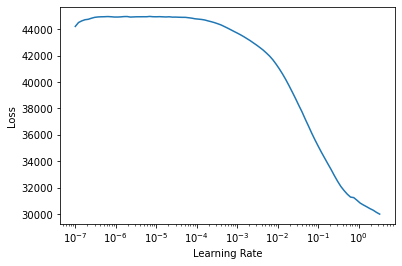

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,l1_b_mean,mu_sd,logvar,l1_latent_reg,weighted_kld,logvar_sd,time


RuntimeError: Given groups=1, weight of size [320, 160, 1, 1], expected input[128, 128, 5, 5] to have 160 channels, but got 128 channels instead

In [ ]:
prefix = f"MMDVae-{'im_size128_bs256'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')